In [1]:
# %pip install opencv-python-headless

In [2]:
def sprint(**kwargs):
    for name, val in kwargs.items():
        print(f"{name}: {val}")


In [3]:
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from PIL import Image, ImageDraw
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from functools import lru_cache

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_BOXES = 1



In [12]:
def split_dataset(img_dir, label_dir, train_ratio=0.7, val_ratio=0.25, test_ratio=0.05, seed=42):
    random.seed(seed)

    IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    LAB_EXT = '.txt'

    image_files = [f for f in sorted(os.listdir(img_dir)) if os.path.splitext(f)[1].lower() in IMG_EXTS]
    label_files = {f for f in os.listdir(label_dir) if f.lower().endswith(LAB_EXT)}

    pairs = []
    for img in image_files:
        base, _ = os.path.splitext(img)
        lbl = base + LAB_EXT
        if lbl in label_files:
            pairs.append((img, lbl))

    random.shuffle(pairs)
    total = len(pairs)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)

    train_pairs = pairs[:n_train]
    val_pairs = pairs[n_train:n_train + n_val]
    test_pairs = pairs[n_train + n_val:]

    return train_pairs, val_pairs, test_pairs


def collate_fixed_boxes(batch, max_boxes=MAX_BOXES):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)

    batch_size = len(targets)

    l_padded = torch.zeros((batch_size, max_boxes, 4), dtype=torch.float32)
    s_padded = torch.zeros((batch_size, max_boxes, 4), dtype=torch.float32)
    for i, target in enumerate(targets):
        l_b = target["l_boxes"]
        l_n = l_b.size(0)
        l_padded[i, :l_n] = l_b[:max_boxes]

        s_b = target["s_boxes"]
        s_n = s_b.size(0)
        s_padded[i, :s_n] = s_b[:max_boxes]
    
    return images, {"l_boxes" : l_padded, "s_boxes" : s_padded}


def resize_image_and_boxes(image, boxes, size):
    """
    image: Tensor[C, H, W]
    boxes: Tensor[N, 4] in (x_min, y_min, x_max, y_max)
    size:   (new_h, new_w)
    """
    _, orig_h, orig_w = image.shape
    new_h, new_w = size

    # Resize image
    image = TF.resize(image, [new_h, new_w])

    # Compute scale factors
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Adjust boxes
    boxes = boxes.clone()
    boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
    boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y

    boxes[:, [4, 6]] = boxes[:, [4, 6]] * scale_x
    boxes[:, [5, 7]] = boxes[:, [5, 7]] * scale_y

    return image, boxes


class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes):
        for t in self.transforms:
            image, boxes = t(image, boxes)
        return image, boxes


class RandomFlip:
    def __init__(self, p_h=0.5, p_v=0.5):
        self.p_h = p_h
        self.p_v = p_v

    def __call__(self, tensor, boxes):
        _, h, w = tensor.shape
        flipped = False

        # Horizontal flip
        if random.random() < self.p_h:
            tensor = TF.hflip(tensor)
            boxes = boxes.clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # flip x_min and x_max
            boxes[:, [4, 6]] = w - boxes[:, [6, 4]]  # flip x_min and x_max
            flipped = True
    
        # Vertical flip
        if random.random() < self.p_v:
            tensor = TF.vflip(tensor)
            boxes = boxes.clone()
            boxes[:, [1, 3]] = h - boxes[:, [3, 1]]  # flip y_min and y_max
            boxes[:, [5, 7]] = h - boxes[:, [7, 5]]  # flip y_min and y_max
            flipped = True
    
        return tensor, boxes


class AddGaussianNoise:
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, boxes):
        noise = torch.randn_like(tensor) * self.std + self.mean
        tensor = torch.clamp(tensor + noise, 0.0, 1.0)
        
        return tensor, boxes


class SyntheticDataset(Dataset):
    def __init__(self, file_pairs, img_dir, label_dir, transform=None, resize=None, test=False):
        self.image_files, self.label_files = zip(*file_pairs)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.resize = resize
        self.test = test

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
            
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise RuntimeError(f"OpenCV failed to load image: {img_path}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(self.label_dir, self.label_files[idx])
        if not os.path.isfile(label_path):
            raise FileNotFoundError(f"Label file not found: {label_path}")
            
        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                box = list(map(int, line.strip().split()))
                boxes.append(box)
                
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Convert to PIL for augmentation if test mode is active
        if self.test:
            pil_image = Image.fromarray(image)
            pil_image = add_random_elements(pil_image, num_elements=3)
            image = np.array(pil_image)

        # Convert to tensor
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.5]*3, std=[0.5]*3)

        if self.resize is not None:
            image, boxes = resize_image_and_boxes(image, boxes, self.resize)

        _, H, W = image.shape

        if self.transform is not None:
            image, boxes = self.transform(image, boxes)

        # normalize xyxy to [0,1]
        # boxes[:, [0,2]] /= H    # x_min, x_max
        # boxes[:, [1,3]] /= W    # y_min, y_max
        
        # now boxes[i] is in [0,1], return these as your GT
        target = {"s_boxes" : boxes[:,:4]}
        target.update({"l_boxes" : boxes[:,4:]})
        
        return image, target



In [13]:
def add_random_elements(image, num_elements=10):
    draw = ImageDraw.Draw(image)
    w, h = image.size

    for _ in range(num_elements):
        shape_type = random.choice(['rectangle']) #'circle'
        color = tuple(random.randint(0, 255) for _ in range(3))
        radius = random.randint(10, 40)

        if shape_type == 'circle':
            x = random.randint(radius, w - radius)
            y = random.randint(radius, h - radius)
            draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=color)

        elif shape_type == 'rectangle':
            x1 = random.randint(0, w - radius)
            y1 = random.randint(0, h - radius)
            x2 = x1 + random.randint(10, radius)
            y2 = y1 + random.randint(10, radius)
            draw.rectangle((x1, y1, x2, y2), fill=color)

    return image



In [14]:
IMAGE_DIR = 'images'
LABEL_DIR = 'labels'
HEATMAP_DIR = 'heatmaps_rgb'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_IMAGES = 500
OUTPUT_DIR = 'data/hm_dataset_min_max'


train_data, valid_data, test_data = split_dataset(
    img_dir = os.path.join(OUTPUT_DIR,IMAGE_DIR),
    label_dir = os.path.join(OUTPUT_DIR,LABEL_DIR)
)

transform = DualCompose([
    RandomFlip(p_h=0.5, p_v=0.5),
    # AddGaussianNoise(mean=0., std=0.05)
])

train_dataset = SyntheticDataset(
    train_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)
valid_dataset = SyntheticDataset(
    valid_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)
test_dataset = SyntheticDataset(
    test_data, os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE,
    test=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fixed_boxes)


In [15]:
print(f"Train/Val/Test sizes: {len(train_dataset)}/{len(valid_dataset)}/{len(test_dataset)}")
for imgs, hms in train_loader:
    print("batch imgs:", imgs.shape, "batch heatmaps:", len(hms))
    break


Train/Val/Test sizes: 3500/1250/250
batch imgs: torch.Size([32, 3, 256, 256]) batch heatmaps: 2


In [16]:
class GridAnchorDetector(nn.Module):
    def __init__(self, in_channels=64, num_anchors=3):
        super().__init__()
        self.box_head = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors, kernel_size=1)

    def forward(self, feat):
        B, C, H, W = feat.shape
        offsets = self.box_head(feat).view(B, -1, 4)
        logits = self.cls_head(feat).view(B, -1)
        
        return offsets, logits


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, padding=1, activation=nn.LeakyReLU, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.block(x)


class AnchorGenerator():
    def __init__(self, stride=8, scales=[32, 64]):
        self.stride = stride
        self.scales = scales

    def generate(self, image_size):
        H = image_size[0] // self.stride
        W = image_size[1] // self.stride

        anchors = torch.empty((H * W * len(self.scales), 4), dtype=torch.float32)
        idx = 0
        for i in range(H):
            cy = (i + 0.5) * self.stride
            for j in range(W):
                cx = (j + 0.5) * self.stride
                
                for scale in self.scales:
                    anchors[idx, 0] = cx - scale / 2
                    anchors[idx, 1] = cy - scale / 2
                    anchors[idx, 2] = cx + scale / 2
                    anchors[idx, 3] = cy + scale / 2
                    idx += 1

        return anchors


class RoundObjectDetector(nn.Module):
    def __init__(self, image_size, iou_threshold=0.25):
        super().__init__()
        self.image_size = image_size
        self.iou_threshold = iou_threshold

        self.conv1 = ConvBlock(3,  16, dropout=0.02)
        self.conv2 = ConvBlock(16, 32, dropout=0.05)
        self.conv3 = ConvBlock(32, 64, dropout=0.10)
        self.pool = nn.MaxPool2d(2, 2)

        self.pool_factor = self._infer_stride(torch.zeros(1, 3, *image_size))
        ag = AnchorGenerator(stride=self.pool_factor, scales=[self.pool_factor*4, self.pool_factor*6, self.pool_factor*8, self.pool_factor*10]) # <-- insert more scales
        num_anchors = len(ag.scales)
        
        self.register_buffer("anchors", ag.generate(image_size))
        # num_anchors = self.anchors.size(0) // ((image_size[0] // self.stride) * (image_size[1] // self.stride))
        self.detector = GridAnchorDetector(in_channels=64, num_anchors=num_anchors)

    def _infer_stride(self, x):
        with torch.no_grad():
            x = self.conv1(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = self.conv3(x)
            feature_map_size = x.shape[2:]  # (H, W)

        stride_h = self.image_size[0] // feature_map_size[0]
        stride_w = self.image_size[1] // feature_map_size[1]

        assert stride_h == stride_w, "Non-square stride detected"
        return stride_h

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        
        offsets, logits = self.detector(x)
        # boxes = decode_offsets_to_boxes(offsets, self.anchors)
        
        return offsets, logits


def decode_offsets_to_boxes(offsets, anchors):
    anchors = anchors.to(offsets.device)
    print("offsets", offsets.shape)
    print("anchors", anchors.shape)

    anchor_centers = (anchors[..., :2] + anchors[..., 2:]) / 2
    anchor_sizes = anchors[..., 2:] - anchors[..., :2]

    pred_centers = offsets[..., :2] * anchor_sizes + anchor_centers
    pred_sizes = torch.exp(offsets[..., 2:]) * anchor_sizes

    boxes = torch.cat([
        pred_centers - pred_sizes / 2,
        pred_centers + pred_sizes / 2
    ], dim=-1)
    
    return boxes  # [B, N, 4]


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


def assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.5):
    B, M, _ = gt_boxes.shape
    N = anchors.size(0)

    valid_mask = gt_boxes.abs().sum(dim=-1) > 0       # [B, M]
    gt_flat = gt_boxes.view(B * M, 4)               # [B*M, 4]
    ious_flat = compute_iou(gt_flat, anchors)         # [B*M, N]
    ious = ious_flat.view(B, M, N)               # [B, M, N]

    ious = ious.masked_fill(~valid_mask.unsqueeze(-1), float('-inf'))
    max_ious, max_idxs = ious.max(dim=1)              # both [B, N]

    object_mask = (max_ious > iou_threshold).float()  # [B, N]
    batch_idx = torch.arange(B, device=gt_boxes.device).unsqueeze(1).expand(-1, N)
    target_boxes = gt_boxes[batch_idx, max_idxs]       # [B, N, 4]
    
    return target_boxes, object_mask  # [B, N, 4], [B, N]


def compute_iou(boxes1, boxes2, mode="iom"):
    M, N = boxes1.size(0), boxes2.size(0)

    # boxes1: [M, 4], boxes2: [N, 4]
    area1 = (boxes1[:,2] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,1])
    area2 = (boxes2[:,2] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,1])

    # intersection
    lt = torch.max(boxes1[:,None,:2], boxes2[:,:2])   # [M, N, 2]
    rb = torch.min(boxes1[:,None,2:], boxes2[:,2:])   # [M, N, 2]

    wh = (rb - lt).clamp(min=0)                        # [M, N, 2]
    inter = wh[:,:,0] * wh[:,:,1]                     # [M, N]

    if mode == "iou":
        union = area1[:,None] + area2[None,:] - inter
        return inter / (union + 1e-8)

    elif mode == "ioa":
        return inter / (area1[:,None] + 1e-8)

    elif mode == "iog":
        return inter / (area2[None,:] + 1e-8)

    elif mode == "iom":
        min_area = torch.min(area1[:,None], area2[None,:])
        return inter / (min_area + 1e-8)

    else:
        raise ValueError(f"Unknown overlap mode: {mode}")


# def match_anchors_to_gt(gt_boxes, anchors, iou_threshold=0.5):
#     B, M, _ = gt_boxes.shape
#     N = anchors.size(0)
#     matched_mask = torch.zeros((B, N), dtype=torch.float32, device=gt_boxes.device)

#     for b in range(B):
#         valid_boxes = gt_boxes[b][gt_boxes[b].abs().sum(dim=-1) > 0]  # [M', 4]
#         if valid_boxes.numel() == 0:
#             continue
        
#         ious = compute_iou(valid_boxes, anchors)  # [M', N]
#         matched_mask[b] = (ious.max(dim=0).values > iou_threshold).float()
    
#     return matched_mask  # [B, N]


def focal_loss(logits, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    # logits: [B, N], targets: [B, N] in {0,1}
    prob = torch.sigmoid(logits)

    # cross-entropy per element
    ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    
    # p_t = prob if target==1 else (1-prob)
    p_t = prob * targets + (1 - prob) * (1 - targets)
    
    # focal factor
    focal_factor = (1 - p_t).pow(gamma)
    
    # alpha weighting
    alpha_factor = alpha * targets + (1 - alpha) * (1 - targets)
    loss = alpha_factor * focal_factor * ce

    if reduction == 'sum':
        return loss.sum()
    
    elif reduction == 'none':
        return loss
    
    return loss.mean()


def encode_boxes_to_offsets(target_boxes, anchors):
    # target_boxes: [B, N, 4], anchors: [N, 4]
    anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2  # [N,2]
    anchor_sizes =  anchors[:, 2:] - anchors[:, :2]      # [N,2]

    # expand to batch size
    B = target_boxes.size(0)
    anchor_centers = anchor_centers.unsqueeze(0).expand(B, -1, -1)
    anchor_sizes = anchor_sizes.unsqueeze(0).expand(B, -1, -1)

    target_centers = (target_boxes[..., :2] + target_boxes[..., 2:]) / 2
    target_sizes = target_boxes[..., 2:] - target_boxes[..., :2]
    
    offsets = torch.zeros_like(target_boxes)
    offsets[..., :2] = (target_centers - anchor_centers) / anchor_sizes
    offsets[..., 2:] = torch.log((target_sizes + 1e-8) / anchor_sizes)

    return offsets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


anchors torch.Size([4096, 4])
l_gt_boxes torch.Size([1, 4])
valid_boxes.shape torch.Size([1, 4])
anchors.shape torch.Size([4096, 4])
torch.Size([1, 4096, 4])
tensor([[[ 50.0000,  84.4000, 161.6000, 199.2000],
         [ 50.0000,  84.4000, 161.6000, 199.2000],
         [ 50.0000,  84.4000, 161.6000, 199.2000],
         ...,
         [ 50.0000,  84.4000, 161.6000, 199.2000],
         [ 50.0000,  84.4000, 161.6000, 199.2000],
         [ 50.0000,  84.4000, 161.6000, 199.2000]]])


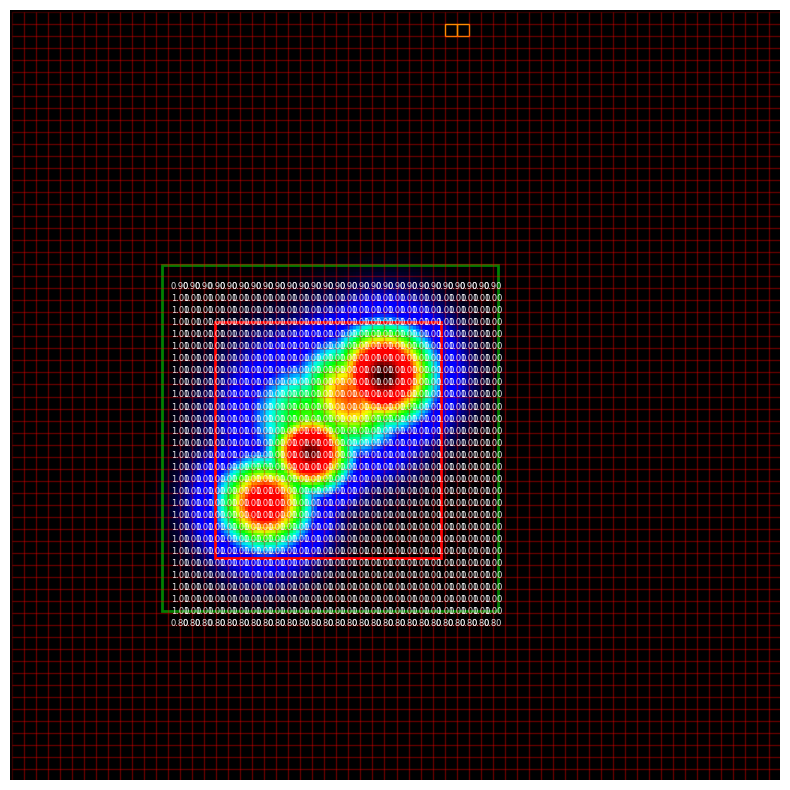

In [20]:
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

def tmp_assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.5):
    B, M = gt_boxes.shape
    N = anchors.size(0)
    target_boxes = torch.zeros((B, N, 4), dtype=torch.float32, device=gt_boxes.device)
    object_mask = torch.zeros((B, N), dtype=torch.float32, device=gt_boxes.device)

    for b in range(B):
        valid_boxes = gt_boxes[b][gt_boxes[b].abs().sum(dim=-1) > 0]  # [M', 4]
        if valid_boxes.numel() == 0:
            continue

        print("valid_boxes.shape", valid_boxes.shape)
        print("anchors.shape", anchors.shape)
        ious = compute_iou(valid_boxes, anchors)  # [M', N]
        max_ious, max_idxs = ious.max(dim=0)  # [N]
        object_mask[b] = (max_ious > iou_threshold).float()
        target_boxes[b] = valid_boxes[max_idxs]  # assign best-matching box to each anchor
        
    return target_boxes, object_mask  # [B, N, 4], [B, N]


# Load and resize
img, label = train_dataset.__getitem__(2)
img = img.permute(1,2,0).numpy()

# Generate anchors
stride_factor = IMAGE_SIZE[0]//pow(2,5)
pool_factor = 4
ag = AnchorGenerator(stride=pool_factor, scales=[pool_factor])
anchors = ag.generate(IMAGE_SIZE)
print("anchors", anchors.shape)

# Set up plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
ax.axis("off")


def tmp_draw_box(box, edgecolor):
    x1, y1, x2, y2 = box
    w,h = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)


# draw GT in red
l_gt_boxes = label['l_boxes']
print("l_gt_boxes", l_gt_boxes.shape)
target_boxes, object_mask = tmp_assign_targets_to_anchors(l_gt_boxes, anchors, iou_threshold=0.50)
print(target_boxes.shape)
print(target_boxes)
object_mask = object_mask[0, :]

if l_gt_boxes is not None:
    for box in l_gt_boxes.tolist():
        tmp_draw_box(box, edgecolor='g')

    ious = compute_iou(anchors, l_gt_boxes)
    # For each anchor, take the highest IoU against any l_box
    max_ious, _ = ious.max(dim=1)  # Tensor [num_anchors]

else:
    # fallback to zeros if no GT
    max_ious = torch.zeros(anchors.size(0))


s_gt_boxes = label['s_boxes']
if s_gt_boxes is not None:
    for box in s_gt_boxes.tolist():
        tmp_draw_box(box, edgecolor='r')


# Choose a colormap for different scales
colors = ["red", "violet", "darkorange", "green"]
scale_idx = (anchors[:,2] - anchors[:,0]).int()
scale_uid = torch.unique(scale_idx).sort().values
scale_idx = (scale_idx.unsqueeze(-1) == scale_uid).long()
scale_idx = scale_idx.argmax(dim=-1)

# Draw each anchor
for idx, (color, box, mask) in enumerate(zip(scale_idx, anchors, object_mask)):
    xmin, ymin, xmax, ymax = box.tolist()

    # Determine color by scale index
    if idx == 100:
        color += 2
        alpha = 1.0
        
    elif idx == 101:
        color += 2
        alpha = 1.0
        
    else:
        alpha = 0.2
    
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor=colors[color],
        facecolor="none",
        alpha=alpha
    )
    ax.add_patch(rect)

    # overlay IoU text (two decimal places)
    if mask == 1:
        iou_val = max_ious[idx].item()
        ax.text(xmin + 1, ymin + 6, f"{iou_val:.2f}", fontsize=6, color='white', alpha=0.9, verticalalignment="top")

plt.tight_layout()
plt.show()


In [33]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

# 1. Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/detector_experiment")

global_step = 0
def train_one_epoch(model, dataloader, optimizer, scheduler, epoch, warmup_epochs, lambda_cls, lambda_reg, max_grad_norm, focal_gamma):
    global global_step
    model.train()
    running_loss = 0.0
    anchors = model.anchors.to(DEVICE)
    
    use_focal = epoch > warmup_epochs
    for images, gt_boxes in dataloader:
        images = images.to(DEVICE)           # [B, 3, H, W]
        gt_boxes = gt_boxes['s_boxes'].to(DEVICE)         # [B, M, 4] padded with zeros

        # forward
        pred_offsets, pred_logits = model(images)   # [B, N, 4], [B, N]

        # with torch.no_grad():
        #     mean_off, std_off = pred_offsets[..., 2:].mean(), pred_offsets[..., 2:].std()
        #     print(f"Scale‐offset μ={mean_off:.4f}, σ={std_off:.4f}")

        # assign anchors → targets
        target_boxes, object_mask = assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=model.iou_threshold)

        # encode boxes
        target_offsets = encode_boxes_to_offsets(target_boxes, anchors)

        # print("pred_offsets", pred_offsets.shape)
        # print("pred_logits", pred_logits.shape)
        # print("target_boxes", target_boxes.shape)
        # print("object_mask", object_mask.shape)
        # print("target_offsets", target_offsets.shape)

        # classification loss
        if use_focal:
            cls_loss = focal_loss(pred_logits, object_mask, gamma=focal_gamma, reduction='sum')
            
        else:
            cls_loss = F.binary_cross_entropy_with_logits(pred_logits, object_mask, reduction='sum')

        cls_loss = cls_loss / object_mask.numel()
        # regression loss (only positives)
        # pos_ratio = object_mask.sum() / object_mask.numel()
        # print(f"[Epoch {epoch}] Positive anchors fraction: {pos_ratio:.3f}")

        pos_mask = object_mask.bool()           # [B, N]
        # Quick debug snippet inside train loop, after assign_targets_to_anchors:
        print(f"Pos anchors: {pos_mask.sum().item()}/{object_mask.numel()} ({pos_mask.sum().item()/object_mask.numel()*100:.2f}%)")
        print("Offset targets μ,σ:", target_offsets[pos_mask].mean().item(), target_offsets[pos_mask].std().item())

        if pos_mask.any():
            reg_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='sum')
            reg_loss = reg_loss / pos_mask.sum()
            
        else:
            reg_loss = torch.tensor(0.0, device=DEVICE)

        # total loss
        # print("lambda_cls * cls_loss", lambda_cls * cls_loss)
        # print("lambda_reg * reg_loss", lambda_reg * reg_loss)
        loss = lambda_cls * cls_loss + lambda_reg * reg_loss

        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        # 2. Log gradient norms per layer
        for name, p in model.named_parameters():
            if p.grad is not None:
                grad_norm = p.grad.norm().item()
                writer.add_scalar(f"grad_norm/{name}", grad_norm, global_step)
        
        # 3. Log current learning rate per param group
        for i, pg in enumerate(optimizer.param_groups):
            lr = pg["lr"]
            writer.add_scalar(f"learning_rate/group_{i}", lr, global_step)
        
        # for name, p in model.named_parameters():
        #     if p.grad is not None:
        #         mean_grad = p.grad.abs().mean().item()
        #         mean_weight = p.data.abs().mean().item()
        #         ratio = mean_grad / (mean_weight + 1e-8)

        #         print(name, ratio)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        global_step += 1

        # 4. At epoch end: log weight distributions
        for name, p in model.named_parameters():
            writer.add_histogram(f"weights/{name}", p.data.cpu().numpy(), epoch)

        # total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        # print(f"Grad norm: {total_norm:.2f}")

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    
    return epoch_loss


def validate_one_epoch(model, dataloader, lambda_cls, lambda_reg):
    model.eval()
    running_loss = 0.0
    anchors = model.anchors.to(DEVICE)

    with torch.no_grad():
        for images, gt_boxes in dataloader:
            images = images.to(DEVICE)
            gt_boxes = gt_boxes['s_boxes'].to(DEVICE)

            pred_offsets, pred_logits = model(images)
            target_boxes, object_mask = assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=model.iou_threshold)
            target_offsets = encode_boxes_to_offsets(target_boxes, anchors)

            cls_loss = F.binary_cross_entropy_with_logits(pred_logits, object_mask)
            pos_mask = object_mask.bool()
            if pos_mask.any():
                reg_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='mean')
                
            else:
                reg_loss = torch.tensor(0.0, device=DEVICE)

            loss = lambda_cls * cls_loss + lambda_reg * reg_loss
            running_loss += loss.item() * images.size(0)

    return running_loss / len(dataloader.dataset)



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hyperparameters ---
NUM_EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
warmup_epochs = 5
lambda_cls = 1.0
lambda_reg = 0.5
max_grad_norm = 5.0
patience = 10
max_focal_gamma = 2.0

# --- Model, Optimizer ---
model = RoundObjectDetector(image_size=IMAGE_SIZE).to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 1. Define (module, lr) pairs in the same order you had before
group_specs = [
    (model.conv1, 1e-6),
    (model.conv2, 1e-6),
    (model.conv3, 1e-6),
    (model.detector.box_head, 5e-4),
    (model.detector.cls_head, 1e-6),
]
bias_lr_factor = 0.1
param_groups = []
for module, base_lr in group_specs:
    # collect weight vs bias params
    w_params = [p for n, p in module.named_parameters() if n.endswith("weight")]
    b_params = [p for n, p in module.named_parameters() if n.endswith("bias")]

    # weight group: keep decay
    param_groups.append({
        "params": w_params,
        "lr": base_lr,
        "weight_decay": 1e-4,
    })

    # bias group: no decay
    param_groups.append({
        "params": b_params,
        "lr": base_lr * bias_lr_factor,
        "weight_decay": 0.0,
    })

# 2. Switch to AdamW so weight_decay is true decoupled
optimizer = optim.AdamW(param_groups, betas=(0.9, 0.999))



In [35]:
import torchvision

def log_predictions(images, gt_boxes, pred_offsets, step):
    # images: [B,3,H,W], gt_boxes: [B, M,4], pred_offsets: [B,N,4]
    anchors = model.anchors.to(images.device)
    # decode preds
    decoded_boxes = decode_offsets_to_boxes(pred_offsets, anchors)  # [B, N,4]

    for i in range(min(2, images.size(0))):  # log first 2 per batch
        img = (images[i] * 255).to(torch.uint8)  # un-normalize if needed
        gt = gt_boxes[i][gt_boxes[i].sum(dim=1) > 0]  # drop padded zeros
        
        # pick top-K predictions by objectness score
        scores = torch.sigmoid(pred_logits[i])
        topk = scores.topk(20).indices
        preds = decoded_boxes[i][topk]

        # draw
        gt_img = torchvision.utils.draw_bounding_boxes(img, gt, colors="green")
        pred_img = torchvision.utils.draw_bounding_boxes(img, preds, colors="red")
        
        # stack side by side
        both = torch.cat([gt_img, pred_img], dim=2)
        writer.add_image(f"preds_vs_gt/{i}", both, step)


In [ ]:
# After computing pred_offsets, pred_logits, and targets:
pos_mask = object_mask.bool()

# 1. Log how many positives you have
num_pos = pos_mask.sum().item()
writer.add_scalar("anchor_stats/num_positive", num_pos, global_step)

# 2. Log IoU distribution of positives
if num_pos > 0:
    tboxes = target_boxes[pos_mask].reshape(-1,4)
    aboxes = anchors[pos_mask].reshape(-1,4)
    ious = box_iou(tboxes, aboxes).diagonal()
    writer.add_histogram("anchor_stats/pos_iou", ious, global_step)

# 3. Track cls accuracy on anchors
pred_probs = torch.sigmoid(pred_logits)
pred_labels = (pred_probs > 0.5).float()
acc = (pred_labels == object_mask).float().mean().item()
writer.add_scalar("cls/anchor_accuracy", acc, global_step)

# 4. Occasionally visualize boxes
if global_step % (len(dataloader)*2) == 0:  # every 2 epochs
    log_predictions(images, gt_boxes, pred_offsets, global_step)


In [34]:
# --- Early Stopping Setup ---
best_val_loss = float("inf")
epochs_no_improve = 0

total_steps = NUM_EPOCHS * len(train_loader)
max_lr = [
    1e-6, 1e-6,   # conv1 weight, bias
    1e-6, 1e-6,   # conv2 weight, bias
    1e-6, 1e-6,   # conv3 weight, bias
    5e-4, 5e-4,   # box_head weight, bias
    1e-6, 1e-6    # cls_head weight, bias
]
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=warmup_epochs/NUM_EPOCHS)

def get_ramp_factor(epoch):
    return min(epoch / warmup_epochs, 1.0)


for epoch in range(1, NUM_EPOCHS + 1):
    ramp = get_ramp_factor(epoch)
    current_lambda_cls = lambda_cls * ramp
    current_focal_gamma = max_focal_gamma * ramp
    
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, epoch, warmup_epochs, current_lambda_cls, lambda_reg, max_grad_norm, focal_gamma=current_focal_gamma)
    
    val_loss = validate_one_epoch(model, valid_loader, current_lambda_cls, lambda_reg)
    
    print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if epoch > warmup_epochs:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "saved_models/best_detector.pth")
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
            
            break


Pos anchors: 27416/393216 (6.97%)
Offset targets μ,σ: 1.073440432548523 2.790536642074585
Pos anchors: 27130/393216 (6.90%)
Offset targets μ,σ: 1.0478821992874146 2.7312405109405518
Pos anchors: 26317/393216 (6.69%)
Offset targets μ,σ: 1.035810112953186 2.6198198795318604
Pos anchors: 26926/393216 (6.85%)
Offset targets μ,σ: 1.0604866743087769 2.8470308780670166
Pos anchors: 24278/393216 (6.17%)
Offset targets μ,σ: 1.0339133739471436 2.6315255165100098
Pos anchors: 26192/393216 (6.66%)
Offset targets μ,σ: 1.0371068716049194 2.578909397125244
Pos anchors: 25817/393216 (6.57%)
Offset targets μ,σ: 1.036434292793274 2.616513967514038
Pos anchors: 28173/393216 (7.16%)
Offset targets μ,σ: 1.0537275075912476 2.7440621852874756
Pos anchors: 21701/393216 (5.52%)
Offset targets μ,σ: 0.9996914863586426 2.517481803894043
Pos anchors: 24922/393216 (6.34%)
Offset targets μ,σ: 1.0397108793258667 2.6794447898864746
Pos anchors: 26512/393216 (6.74%)
Offset targets μ,σ: 1.0336722135543823 2.603568077087

KeyboardInterrupt: 

In [ ]:
# plot_tb_scalars.py
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_scalars(logdir, tag):
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={event_accumulator.SCALARS: 0}  # load all scalars
    )
    ea.Reload()
    events = ea.Scalars(tag)  # list of Event(step, wall_time, value)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

def plot_tags(logdir, tags):
    plt.figure(figsize=(8, 5))
    for tag in tags:
        steps, vals = load_scalars(logdir, tag)
        plt.plot(steps, vals, label=tag)
        
    plt.xlabel("Global Step")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

LOGDIR = "runs/detector_experiment"  # same as your SummaryWriter log_dir
TAGS = [
    "learning_rate/group_0",
    "learning_rate/group_3",
    "grad_norm/conv1.block.0.weight",
    "grad_norm/conv2.block.0.bias",
    "grad_norm/conv2.block.0.weight",
    "grad_norm/conv3.block.0.bias",
    "grad_norm/conv3.block.0.weight",
    "grad_norm/conv1.block.0.weight",
    "grad_norm/conv1.block.0.bias",
    "grad_norm/detector.box_head.weight",
    "grad_norm/detector.box_head.bias",
    "grad_norm/detector.cls_head.weight",
    "grad_norm/detector.cls_head.bias",
    # add more tags as desired
]
plot_tags(LOGDIR, TAGS)


In [ ]:
model = RoundObjectDetector(image_size=IMAGE_SIZE).to(DEVICE)

PATH = "saved_models/best_detector.pth"
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

model.eval() is not None

[0.52079713 0.45809314 0.5029507  ... 0.43668932 0.4767969  0.45280138]


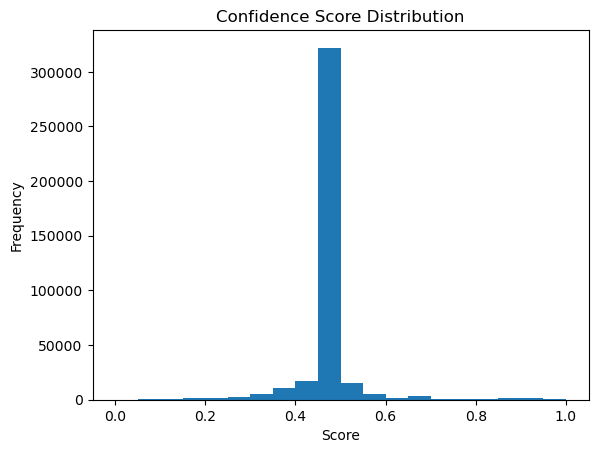

In [37]:
import matplotlib.pyplot as plt

conf_logits_list = []
model.eval()
with torch.no_grad():
    images, _ = next(iter(valid_loader))
    images = images.to(DEVICE)
    _, conf_logits = model(images)
    conf_logits_list.append(conf_logits)
    conf_scores = torch.sigmoid(conf_logits)

conf_scores = conf_scores.cpu().flatten().numpy()
print(conf_scores)
plt.hist(conf_scores, bins=20, range=(0, 1))
plt.title("Confidence Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


offsets torch.Size([32, 12288, 4])
anchors torch.Size([12288, 4])
0.9999999195643541
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9778071045875549, tensor([136.6811, 136.6811, 143.0900, 143.0900])), (0.976504385471344, tensor([135.2979, 135.1679, 148.2461, 148.3712]))]


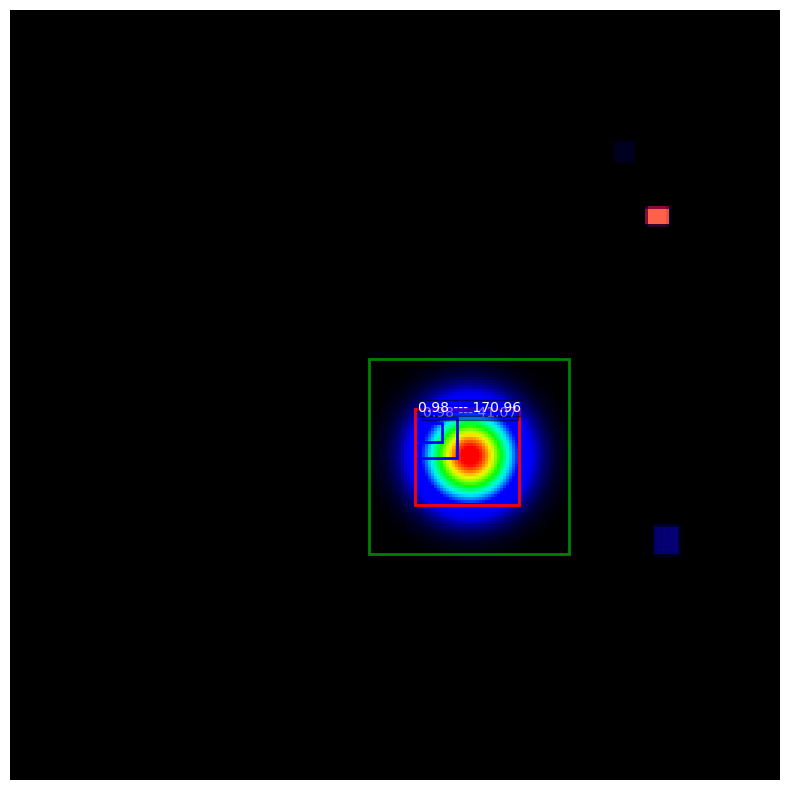

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999195643573
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9816505312919617, tensor([ 65.8869, 129.8312,  72.2957, 136.2401])), (0.9814716577529907, tensor([ 49.2947, 102.0350,  89.7897, 173.0494]))]


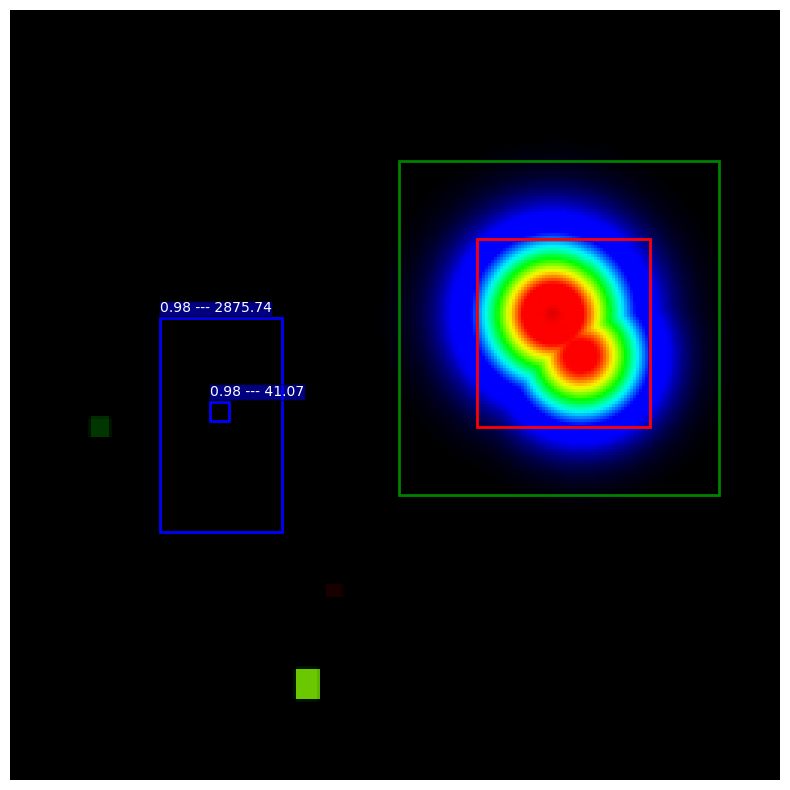

0.9999999195643573
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995105].


[(0.9859885573387146, tensor([224.7248, 132.7245, 250.3603, 158.3600])), (0.9739412069320679, tensor([140.7245, 128.7245, 166.3599, 154.3599]))]


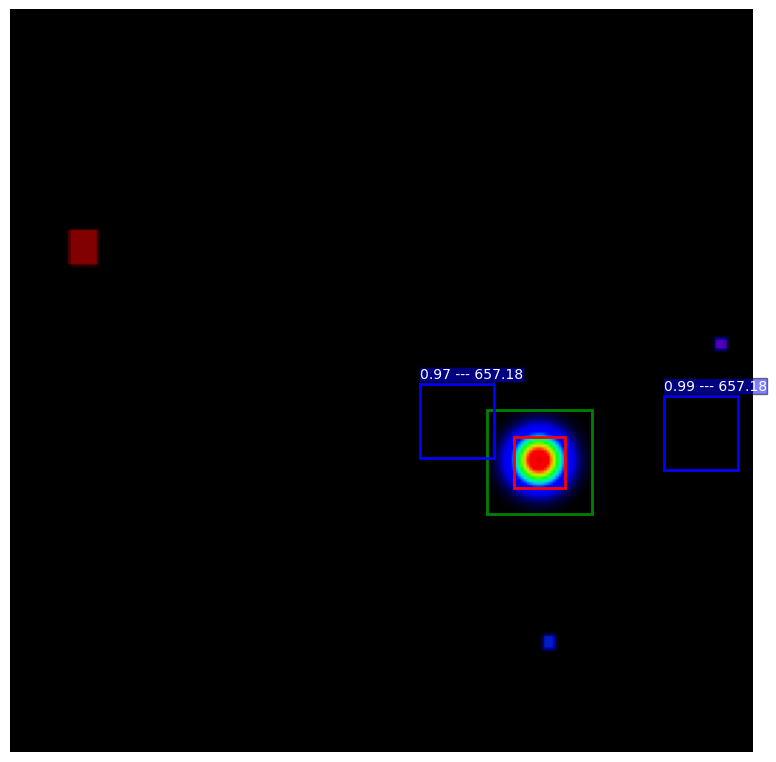

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999597821787
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9827542901039124, tensor([219.3029, 119.3029, 231.6810, 131.6810])), (0.9815322160720825, tensor([216.6057, 116.6057, 241.3621, 141.3621]))]


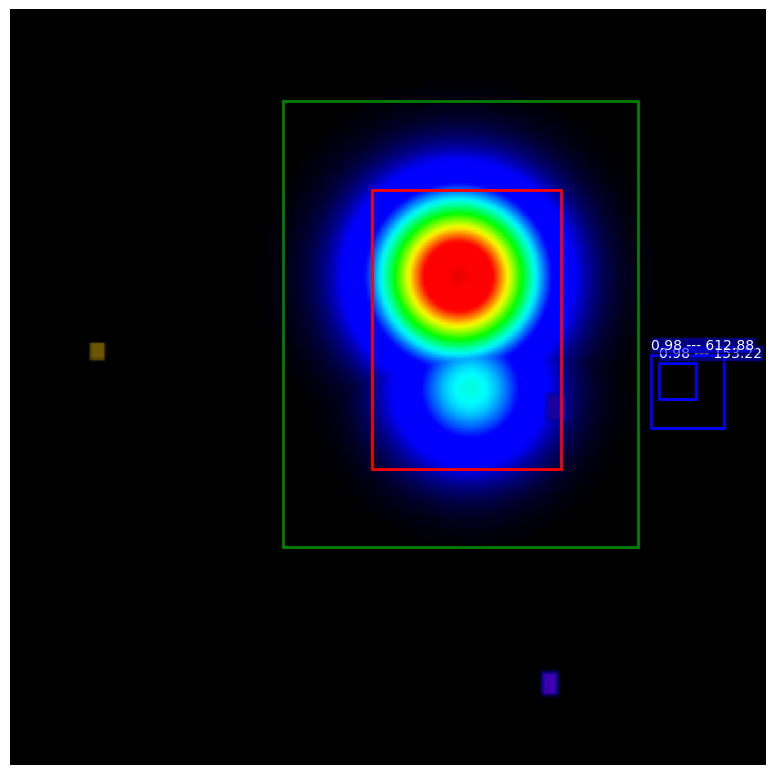

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999597821787
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9911321997642517, tensor([220.6807, 148.6807, 227.0865, 155.0865])), (0.9880480766296387, tensor([212.7229, 144.7229, 238.3461, 170.3461]))]


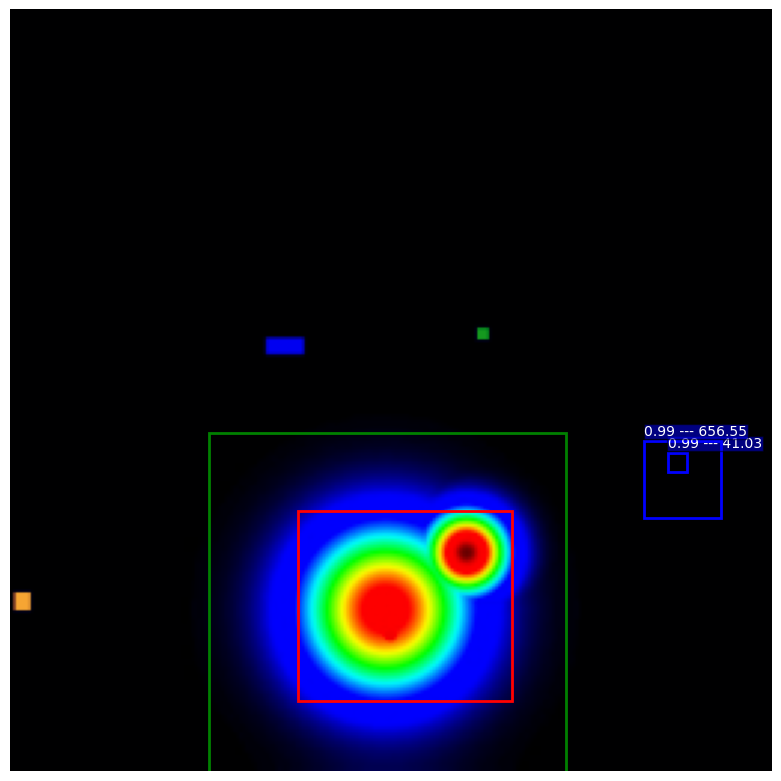

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999597821787
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9803903698921204, tensor([120.6811, 144.6811, 127.0900, 151.0900])), (0.9755673408508301, tensor([ 15.4482, 135.2632,  67.0765, 184.3976]))]


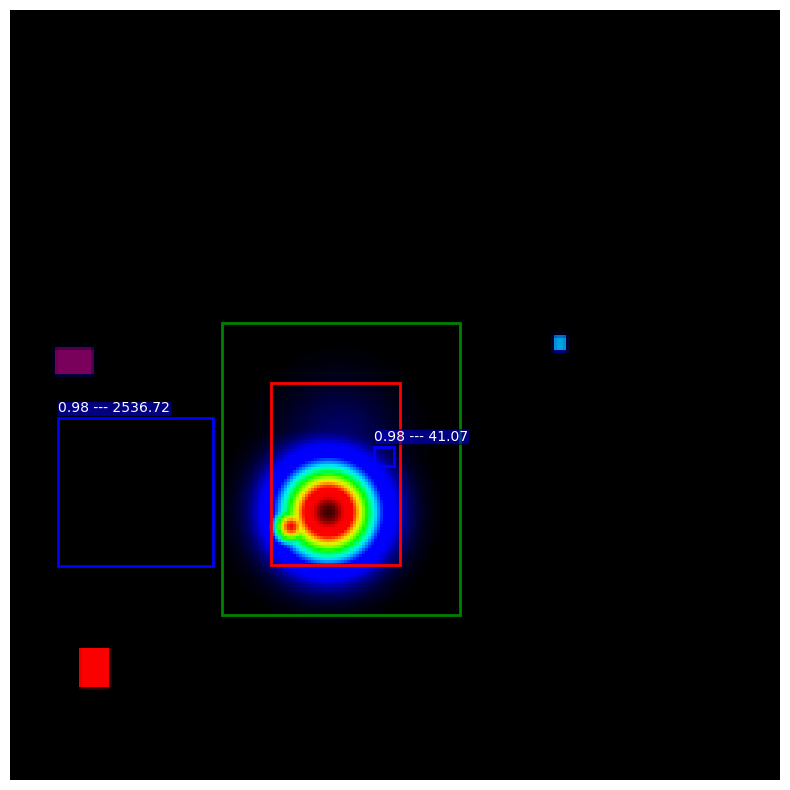

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99983674].


0.9999999195643541
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9809141159057617, tensor([ 65.8869, 141.8312,  72.2957, 148.2401])), (0.9718350172042847, tensor([149.7738, 137.6624, 162.5915, 150.4801]))]


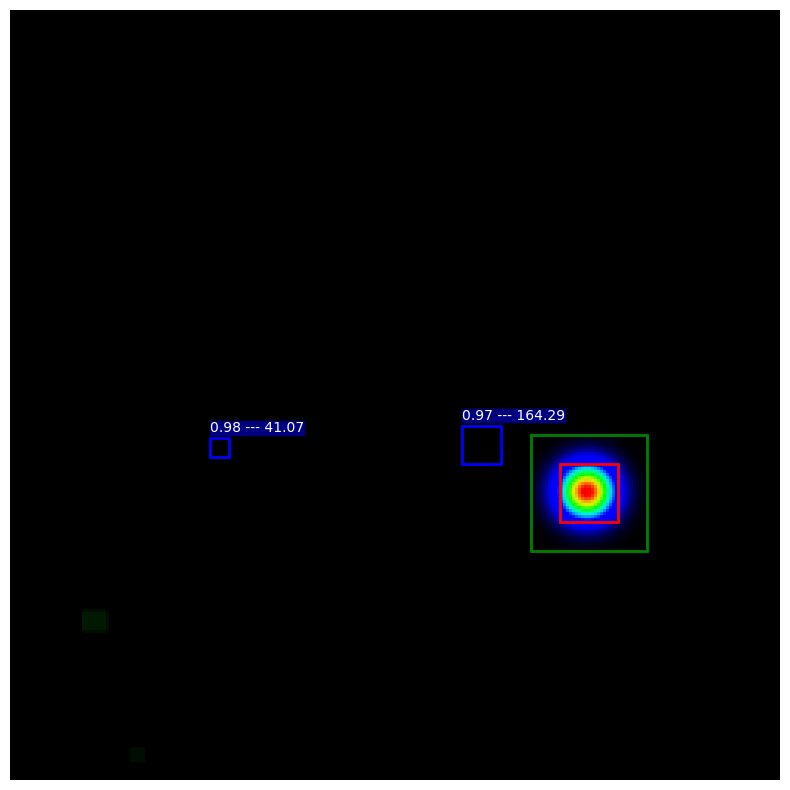

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999195643541
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9825565218925476, tensor([136.7245, 128.7245, 162.3599, 154.3599])), (0.9788638949394226, tensor([139.3622, 131.3622, 152.1800, 144.1800]))]


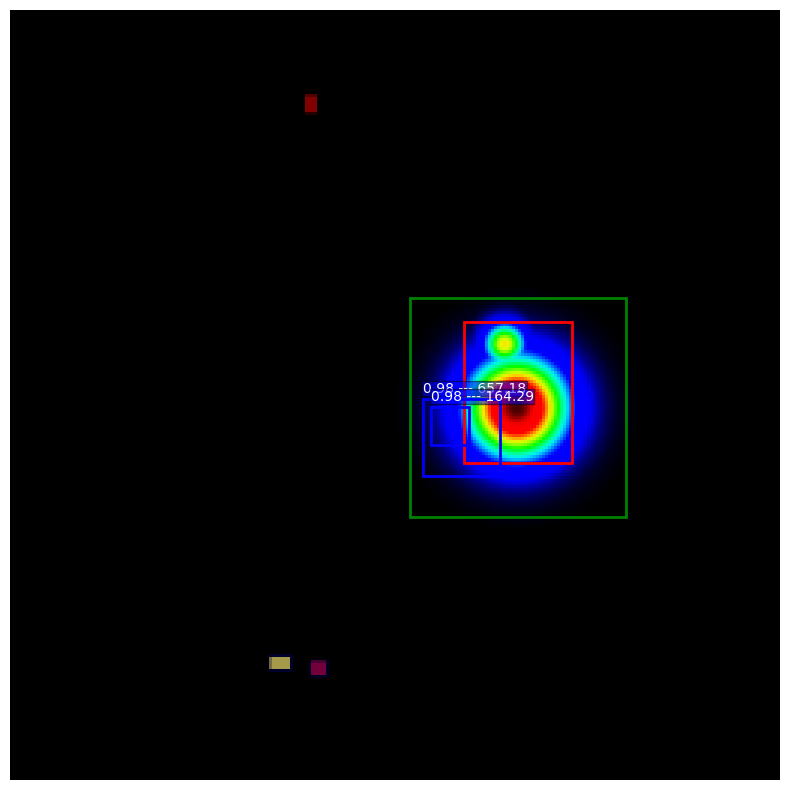

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999195643541
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9841406345367432, tensor([112.6551, 148.6551, 118.8697, 154.8697])), (0.9769464135169983, tensor([111.3102, 147.3102, 123.7393, 159.7393]))]


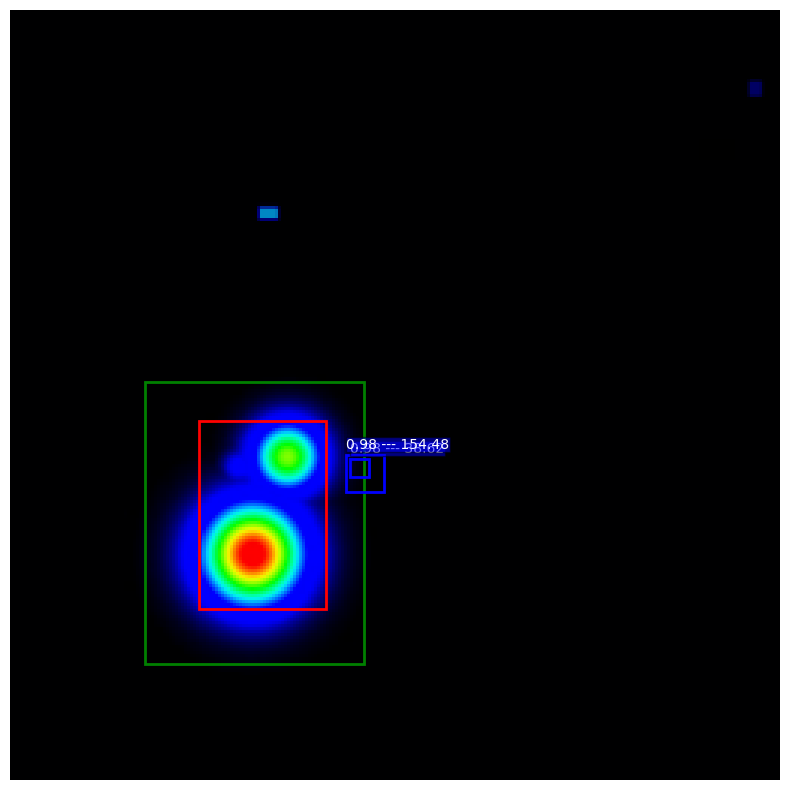

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0.9999999195643573
Image shape: torch.Size([3, 256, 256])
 GT boxes: torch.Size([1, 4])
Pred boxes+conf: 12288 x 5

torch.Size([12288, 4])
[(0.9874517321586609, tensor([207.2795, 119.1393, 224.2125, 136.3526])), (0.9845985174179077, tensor([204.6057, 120.6057, 229.3621, 145.3621]))]


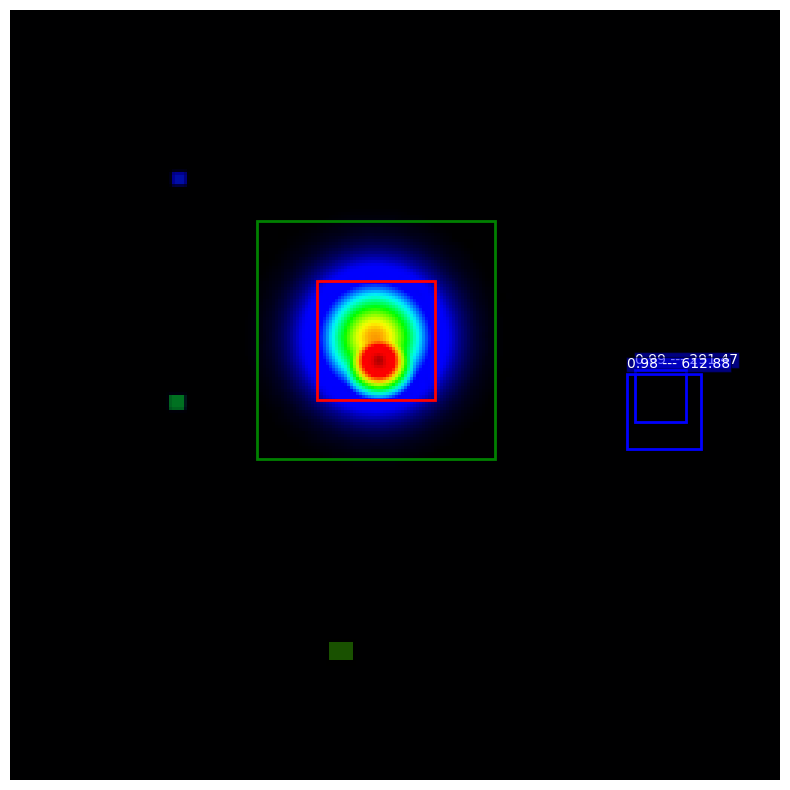

In [38]:
def show_boxes_with_confidence(image_tensor, l_gt_boxes=None, s_gt_boxes=None, pred_boxes=None, confidences=None, figsize=(8,8), box_kwargs=None, text_kwargs=None):
    """
    Draw GT (red) and predicted (blue) boxes.  
    If confidences is provided, writes 'c=0.83' at top-left of each pred box.
    """

    num_boxes = 2
    
    # defaults
    box_kwargs = box_kwargs or {}
    text_kwargs = text_kwargs or dict(color='white', fontsize=10, bbox=dict(facecolor='blue', alpha=0.5, pad=0.5))

    # prep image
    img = image_tensor.permute(1,2,0).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')

    ax = plt.gca()

    def _draw_box(box, edgecolor):
        x1, y1, x2, y2 = box
        w,h = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none', **box_kwargs)
        ax.add_patch(rect)

    # draw GT in red
    if l_gt_boxes is not None:
        for box in l_gt_boxes.tolist():
            _draw_box(box, edgecolor='g')

    if s_gt_boxes is not None:
        for box in s_gt_boxes.tolist():
            _draw_box(box, edgecolor='r')

    # draw preds in blue + text
    if pred_boxes is not None:
        best_boxes = dict(zip(confidences, pred_boxes))
        best_boxes = dict(sorted(best_boxes.items(), key=lambda item: -item[0]))
        best_boxes = list(best_boxes.items())[:num_boxes]
        print(best_boxes)
        for i, (conf, box) in enumerate(best_boxes):
            if conf >= 0.25:
                _draw_box(box, edgecolor='b')
                if confidences is not None:
                    x1,y1, x2, y2 = box
                    area = (x2 - x1) * (y2 - y1)
                    ax.text(x1, y1 - 2, f"{conf:.2f} --- {area:.2f}", **text_kwargs)

    plt.tight_layout()
    plt.show()




num_images = 10
init_image = random.randint(0, len(test_loader))
for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(DEVICE)

    # Forward whole batch at once
    with torch.no_grad():
        all_coords, all_confs = model(inputs)
        all_coords = decode_offsets_to_boxes(all_coords, model.anchors)
        all_confs = torch.sigmoid(all_confs)

    # Loop over images in batch
    for img, l_gt, s_gt, coords, confs in zip(inputs[init_image:init_image+num_images], labels['l_boxes'][init_image:init_image+num_images], labels['s_boxes'][init_image:init_image+num_images], all_coords[init_image:init_image+num_images], all_confs[init_image:init_image+num_images]):
        # Move to CPU / numpy for printing & plotting
        img = img.to(DEVICE)
        H, W = img.shape[1:]
        l_gt = l_gt.to(DEVICE)
        s_gt = s_gt.to(DEVICE)

        coords = coords.to(DEVICE)   # list of [x1,y1,x2,y2]
        coords_px = coords
        coords_px = coords_px.tolist()
        print((coords_px[0][2]-coords_px[0][0])/(coords_px[0][3]-coords_px[0][1]))

        confs = confs.to(DEVICE).tolist()    # list of floats in [0,1]

        print(f"Image shape: {img.shape}")
        print(f" GT boxes: {l_gt.shape}")
        print(f"Pred boxes+conf: {len(coords)} x 5\n")

        # Print each box + its confidence
        print(coords.shape)
        # for (x1,y1,x2,y2), c in zip(coords, confs):
        #     if c > 0.75:
        #         print(f"  → Box: [{x1:.4f},{y1:.4f},{x2:.4f},{y2:.4f}]  conf={c:.4f}")
        
        # print()

        # Visualize (with confidences overlaid)
        show_boxes_with_confidence(img, l_gt_boxes=l_gt, s_gt_boxes=s_gt, pred_boxes=coords, confidences=confs)

    break